# 2 - Solving a Stackelberg game

## 2.1 - Start

The previous analysis reflects a strategic game in normal form, where both players have full visibility on the graph and payoff matrix, 
which allows each to calculate the optimal strategy in response to their opponents decision. In a more realistic scenario, defending 
forces may have deployed the jammer to an optimal strategy node in anticipation of an attack. The hostile forces operating the drone 
may have collected intelligence about the environment which tells where the jammer currently is located. The defender has the opportunity 
to relocate the jammer to any other node at any time. \textit{Include: limited jammer mobility, observation of drone when entering the 
area, adaptive defense by reclocating jammer in response to drone's move.}

We extend the original \textit{Game of Drones} by introducing sequential decision-making under partial information. In this variant, the jammer first occupies a node in the graph, mimicking a Stackelberg leader's announcement. The drone, acting as a follower, selects one of three possible starting nodes and an appropriate route to a common target. After this commitment, the jammer may move again to optimize interference.

We model a sequential decision-making game between a \emph{jammer} (leader) and a \emph{drone} (follower) on a static undirected graph $G = (V, E)$. The drone must reach a designated target node $T \in V$ from one of three potential start nodes $\mathcal{S} = \{s_1, s_2, s_3\} \subset V$. The jammer places itself at a node $j_0 \in V$ and may later relocate to an adjacent node $j_1 \in \mathcal{N}(j_0) \cup \{j_0\}$, after observing the drone's committed route.

The game proceeds in three stages:

* Stage 1 - The jammer commits to an initial position $j_0 \in V$.
* Stage 2 - The drone selects a starting node $s_k \in \mathcal{S}$ and a path $p = (v_0, v_1, \dots, v_\ell)$ from $s_k$ to the target node $T$ such that the total path length $L(p) \leq B$, where $B$ is the drone's range budget.
* Stage 3 - The jammer observes the drone when at its chosen starting node $s_k$ and may move to a neighbouring node $j_1 \in \mathcal{N}(j_0) \cup \{j_0\}$ to maximize the total risk imposed on the drone.


Given the initial jammer position \[j_0]\ and path $p$, the jammer chooses a reactive position:

\begin{equation}
j_1^*(p, j_0) = \arg\max_{j \in \mathcal{N}(j_0) \cup \{j_0\}} R(p, j).
\end{equation}

This is comparable to solving the sequential game with a limited set of available jammer positions and a defined path for the drone. Then the drone’s utility function is:

\begin{equation}
    u(p, j_0) = \frac{-(\gamma \cdot R(p, j_1^*(p, j_0)) + L(p) )}{\gamma + B},
\end{equation}

with

\begin{equation}
    \gamma = \frac {\Delta L_{\max}} {\delta R_{\min}}
\end{equation}

and where $\gamma > 0$ is the weight factor emphasizing risk over distance. Next, the drone now solves the following optimisation problem for a limited set of jammer nodes, anticipating the jammer's optimal repositioning:

\begin{equation}
    p^* = \arg\max_{\substack{p \in \mathcal{P}_{s_k T} \\ L(p) \leq B \\ s_k \in \mathcal{S}}} u(p, j_0),
\end{equation}

For the Stackelberg game, we use a slightly different graph, which now includes a set $S$ of possible starting nodes for the drone.

Simulation date 06112025 at 11:10:33
Output file name starts with: '20251106_111010_vSB_'



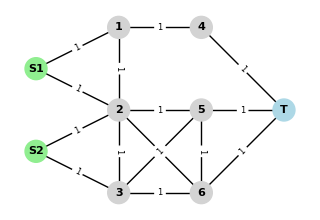

In [15]:
from IPython.display import display, Latex

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import datetime as dt
import LATEXsupport as ls
from itertools import combinations, product
import pandas as pd


# define administrative arrangements:
version = 'SB'
now = dt.datetime.now()
outfile_header = f"{now.year}{now.month:02d}{now.day:02d}_{now.hour:02d}{now.minute:02d}{now.minute:02d}_v{version}_"
print(f"Simulation date {now.day:02d}{now.month:02d}{now.year} at {now.hour:02d}:{now.minute:02d}:{now.second:02d}")
print(f"Output file name starts with: '{outfile_header}'\n")

# Generate the graph from the paper:
G = nx.Graph()

# Add nodes (vertices)
nodes = ['S1', 'S2', '1', '2', '3', '4', '5', '6', 'T']
jammer_nodes = ['1', '2', '3', '4', '5', '6']
G.add_nodes_from(nodes)

# Add edges with distances
edges = [
    ('S1', '1', 1), ('S1', '2', 1), ('S2', '2', 1), ('S2', '3', 1),
    ('1', '2', 1), ('1', '4', 1), ('2', '3', 1), ('2', '5', 1), ('2', '6', 1),
    ('3', '5', 1), ('3', '6', 1),
    ('4', 'T', 1), ('5', 'T', 1), ('5', '6', 1), ('6', 'T', 1)
]

for u, v, d in edges:
    G.add_edge(u, v, weight=d)

# Set positions for drawing
pos = {
    'S1': (0, 3), 'S2': (0, 1),
    '1': (1, 4), '2': (1, 2), '3': (1, 0), '4': (2, 4), '5': (2, 2), '6': (2, 0),
    'T': (3, 2)
}

# Draw the graph
def draw_graph(G, pos, fig_close=False):

    color_map = ['lightgreen' if node in ['S1','S2'] else 'lightblue' if node == 'T' else 'lightgrey' for node in G]

    plt.figure(figsize=(3, 2))
    nx.draw(G, pos, with_labels=True, node_color=color_map,
            node_size=250, font_size=8, font_weight='bold')
    
    # Draw edge labels
    edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    
   #plt.title("Graph for Drone-Jammer Game", fontsize=15)
    plt.savefig(f'{outfile_header}graph.png', dpi=300, bbox_inches='tight')

    if fig_close:
        plt.close()

draw_graph(G, pos, fig_close=False)

## 2.2 Set variables for this game

Although the same as for the sequential game, we redefine as if nothing happened earlier.

In [16]:
# Drone
start_nodes = ['S1', 'S2']
battery_range = 5

# Jammer's risk impact on adjacent edges
p_edge = 0.5
jammer_pos_step_1 = '2'

# Target
target = 'T'

# Algorithms
gamma = 1000   

# Simulation
DEBUG = False


## 2.3 Risk and Path length

Define the functions to calculate the length and risk for each path, same as above

In [17]:
# Function to calculate the risk of a given path for a given jammer position
def calculate_risk(path, jammer_pos):
    total_risk = 1  # Start with 1, and we'll multiply to calculate the total path risk
    for u, v in zip(path[:-1], path[1:]):
        # If edge is adjacent to jammer, risk = 0.5 for that edge
        if u == jammer_pos or v == jammer_pos:
            total_risk *= (1 - 0.5)  # Risk = 0.5 for the edge
        else:
            total_risk *= 1  # No risk if the edge is not adjacent to the jammer
    return 1 - total_risk  # The total path risk is 1 minus the product of the edge risks

# Function to calculate the length of a path (number of edges)
def calculate_length(path):
    return len(path) - 1  # The length is the number of edges, not nodes

# Function to calculate the drone's utility based on risk and length
def calculate_utility(path, jammer_pos, gamma=1000):
    risk = calculate_risk(path, jammer_pos)
    length = calculate_length(path)
    
    # If risk is zero, the utility is just negative of the length
    if risk == 0:
        return -length  # If no risk, utility is just negative of the length
    else:
        return -gamma * risk - length  # If there is risk, consider both risk and length


## 2.4 Find all paths

Use networkx (DST search) to find all possible paths between S and T. This function is defined here but will be used in the next section where the drone's best response is calculated.

In [18]:
# Function to find all paths from a start node to the target node (T)
def find_paths(start, target, max_length, DEBUG):
    all_paths = list(nx.all_simple_paths(G, source=start, target=target))
    valid_paths = [path for path in all_paths if len(path) <= max_length]

    if DEBUG:
        print("Function 'find_paths'")
        print(f"  Path {start} to {target} with B={max_length}")
    
    return valid_paths



## 2.5 Drone's best response

Define the function to calculate the best response from the drone given the jammer's initial position.

In [19]:
# Function to calculate the best path for the drone given the jammer's initial position
def drone_best_response(jammer_pos, start_nodes, target, max_length, DEBUG):
    best_utility = float('-inf')
    best_path = None
    print(f"Evaluating best path given jammer at {jammer_pos}")
    
    for start in start_nodes:
        print(f"  Checking start node: {start}")
        paths = find_paths(start, target, max_length, DEBUG)
        for path in paths:
            utility = calculate_utility(path, jammer_pos)
            if DEBUG:
                print(f"    Path: {path}, Utility: {utility}")
            if utility > best_utility:
                best_utility = utility
                best_path = path
    return best_path, best_utility


## 2.6 Jammer's best response

Define the function to calculate the best response from the drone given the jammer's initial position.

In [20]:
# Function to calculate the jammer's best strategy based on drone's response
def jammer_best_strategy(start_nodes, target, max_length, current_jammer_pos, DEBUG):
    # Find the best response of the drone for each possible jammer move
    best_jammer_pos = None
    best_jammer_utility = float('-inf')  # Maximize jammer's utility (minimize drone's utility)

    # Evaluate each possible move the jammer can make
    adjacent_nodes_to_jammer = list(G.neighbors(current_jammer_pos))

    for new_jammer_pos in adjacent_nodes_to_jammer:
        print(f"Evaluating jammer position {new_jammer_pos}")
        
        # Drone responds to the jammer's move
        best_drone_path, best_drone_utility = drone_best_response(new_jammer_pos, 
                                                                  start_nodes, target, 
                                                                  max_length, 
                                                                  DEBUG)
        
        # Calculate the jammer's utility (zero-sum game)
        jammer_utility = -best_drone_utility
        print(f"Jammer's utility for moving to {new_jammer_pos}: {jammer_utility}")

        # We want to maximize the jammer's utility
        if jammer_utility > best_jammer_utility:
            best_jammer_utility = jammer_utility
            best_jammer_pos = new_jammer_pos

    return best_jammer_pos, best_jammer_utility

## 2.7 Generate the Payoff Matrix

# 3 Solving the Stackelberg game

Assuming the jammer announces a particular position as the Stackelberg leader. The drone is informed about this choice of the defenders/jammer. Next, the drone determines the best path as response to the jammer's choice.

In [21]:
# Find the best response of the drone to the jammer's first move
best_drone_path, best_drone_utility = drone_best_response(jammer_pos_step_1, 
                                                          start_nodes, target, 
                                                          battery_range, 
                                                          DEBUG)

print(f"Best path for drone given jammer at {jammer_pos_step_1}: {best_drone_path}")
print(f"Drone's utility for this path: {best_drone_utility}")

# Now evaluate the best path for the jammer to move to
best_jammer_pos_step_3, best_jammer_utility_step_3 = jammer_best_strategy(start_nodes, target, 
                                                                          battery_range, jammer_pos_step_1, 
                                                                          DEBUG)

print(f"Best jammer position after move: {best_jammer_pos_step_3}")
print(f"Jammer's utility after moving: {best_jammer_utility_step_3}")

Evaluating best path given jammer at 2
  Checking start node: S1
  Checking start node: S2
Best path for drone given jammer at 2: ['S1', '1', '4', 'T']
Drone's utility for this path: -3
Evaluating jammer position S1
Evaluating best path given jammer at S1
  Checking start node: S1
  Checking start node: S2
Jammer's utility for moving to S1: 3
Evaluating jammer position S2
Evaluating best path given jammer at S2
  Checking start node: S1
  Checking start node: S2
Jammer's utility for moving to S2: 3
Evaluating jammer position 1
Evaluating best path given jammer at 1
  Checking start node: S1
  Checking start node: S2
Jammer's utility for moving to 1: 3
Evaluating jammer position 3
Evaluating best path given jammer at 3
  Checking start node: S1
  Checking start node: S2
Jammer's utility for moving to 3: 3
Evaluating jammer position 5
Evaluating best path given jammer at 5
  Checking start node: S1
  Checking start node: S2
Jammer's utility for moving to 5: 3
Evaluating jammer position 6

In [22]:
S1T = find_paths('S1', 'T', 5, False)
S2T = find_paths('S2', 'T', 5, False)

for p in S1T:
    print(p)
for p in S2T:
    print(p)

print(f"Path lengths are S1T: {len(S1T)} and S2T: {len(S2T)}")
print(f"Total length of paths from [S1, S2] to T is: {len(S1T)+len(S2T)} paths")

['S1', '1', '2', '5', 'T']
['S1', '1', '2', '6', 'T']
['S1', '1', '4', 'T']
['S1', '2', '1', '4', 'T']
['S1', '2', '3', '5', 'T']
['S1', '2', '3', '6', 'T']
['S1', '2', '5', 'T']
['S1', '2', '5', '6', 'T']
['S1', '2', '6', '5', 'T']
['S1', '2', '6', 'T']
['S2', '2', '1', '4', 'T']
['S2', '2', '3', '5', 'T']
['S2', '2', '3', '6', 'T']
['S2', '2', '5', 'T']
['S2', '2', '5', '6', 'T']
['S2', '2', '6', '5', 'T']
['S2', '2', '6', 'T']
['S2', '3', '2', '5', 'T']
['S2', '3', '2', '6', 'T']
['S2', '3', '5', 'T']
['S2', '3', '5', '6', 'T']
['S2', '3', '6', '5', 'T']
['S2', '3', '6', 'T']
Path lengths are S1T: 10 and S2T: 13
Total length of paths from [S1, S2] to T is: 23 paths


# 4 Backward induction for Stackelberg game

The following code provides further analysis for the Stackelberg game specifically on the graph defined above. This code should demoonstrate how backward induction can support solving these kinds of games.

## 4.1 Backward Induction: Stage 3



In [23]:
# Re-import necessary libraries after kernel reset
import networkx as nx
import pandas as pd
from itertools import product

# Define the graph
G = nx.Graph()
nodes = ['S1', 'S2', '1', '2', '3', '4', '5', '6', 'T']
G.add_nodes_from(nodes)

edges = [
    ('S1', '1', 1), ('S1', '2', 1), ('S2', '2', 1), ('S2', '3', 1),
    ('1', '2', 1), ('1', '4', 1), ('2', '3', 1), ('2', '5', 1), ('2', '6', 1),
    ('3', '5', 1), ('3', '6', 1),
    ('4', 'T', 1), ('5', 'T', 1), ('5', '6', 1), ('6', 'T', 1)
]
G.add_weighted_edges_from(edges)

# Constants
jammer_nodes = ['S1', 'S2','1', '2', '3', '4', '5', '6', 'T']
gamma = 1000
B = 5  # battery constraint

# Utility functions
def compute_risk(path_edges, jammer_node):
    affected = [(u, v) for (u, v) in path_edges if jammer_node in (u, v)]
    k = len(affected)
    return 1 - (1 - 0.5)**k if k > 0 else 0.0

def compute_ud(path_edges, jammer_node):
    risk = compute_risk(path_edges, jammer_node)
    length = len(path_edges)
    if length > B:
        return -float('inf')
    return -gamma * risk - length

def compute_uj(path_edges, jammer_node):
    risk = compute_risk(path_edges, jammer_node)
    length = len(path_edges)
    if length > B:
        return -float('inf')
    return gamma * risk + length

# All simple paths from each start node to T within battery limit
start_nodes = ['S1', 'S2']
all_paths = {}
for s in start_nodes:
    simple_paths = list(nx.all_simple_paths(G, source=s, target='T', cutoff=B))
    all_paths[s] = [p for p in simple_paths if len(p) - 1 <= B]

# Stage 3: for each (j0, sk), find j1* for all paths from sk
stage3_results = []

for j0 in jammer_nodes:
    neighbors = neighbors = list(G.neighbors(j0)) + [j0] # j1 options include node T, S1 and S2 as candidate
    for sk in start_nodes:
        paths = all_paths[sk]
        for j1 in neighbors:
            uj_vals = [compute_uj(list(zip(p[:-1], p[1:])), j1) for p in paths]
            min_uj = min(uj_vals)
            stage3_results.append((j0, sk, j1, min_uj))

# Find optimal j1* for each (j0, sk)
df = pd.DataFrame(stage3_results, columns=['j0', 'start_node', 'j1_candidate', 'min_Uj'])
optimal_j1 = df.groupby(['j0', 'start_node']).apply(lambda x: x[x['min_Uj'] == x['min_Uj'].max()]).reset_index(drop=True)
optimal_j1.sort_values(['j0', 'start_node'], inplace=True)
optimal_j1.head(50)


/tmp/ipykernel_1675355/4207714192.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  optimal_j1 = df.groupby(['j0', 'start_node']).apply(lambda x: x[x['min_Uj'] == x['min_Uj'].max()]).reset_index(drop=True)


,j0,start_node,j1_candidate,min_Uj
0,1,S1,S1,503.0
1,1,S2,S1,3.0
2,1,S2,2,3.0
3,1,S2,4,3.0
4,1,S2,1,3.0
5,2,S1,S1,503.0
6,2,S2,S2,503.0
7,3,S1,S2,3.0
8,3,S1,2,3.0
9,3,S1,5,3.0


In [24]:
len(optimal_j1)

29

In [25]:
simple_paths = list(nx.all_simple_paths(G, source='S1', target='T', cutoff=5))
for p in simple_paths:
    print(p)

['S1', '1', '2', '3', '5', 'T']
['S1', '1', '2', '3', '6', 'T']
['S1', '1', '2', '5', 'T']
['S1', '1', '2', '5', '6', 'T']
['S1', '1', '2', '6', '5', 'T']
['S1', '1', '2', '6', 'T']
['S1', '1', '4', 'T']
['S1', '2', 'S2', '3', '5', 'T']
['S1', '2', 'S2', '3', '6', 'T']
['S1', '2', '1', '4', 'T']
['S1', '2', '3', '5', 'T']
['S1', '2', '3', '5', '6', 'T']
['S1', '2', '3', '6', '5', 'T']
['S1', '2', '3', '6', 'T']
['S1', '2', '5', '3', '6', 'T']
['S1', '2', '5', 'T']
['S1', '2', '5', '6', 'T']
['S1', '2', '6', '3', '5', 'T']
['S1', '2', '6', '5', 'T']
['S1', '2', '6', 'T']


In [26]:
## 3.2.1 Aggregated box plot as visual

In [29]:
##### Re-import libraries after environment reset
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Redefine the graph
G = nx.Graph()
nodes = ['S1', 'S2', '1', '2', '3', '4', '5', '6', 'T']
edges = [
    ('S1', '1', 1), ('S1', '2', 1), ('S2', '2', 1), ('S2', '3', 1),
    ('1', '2', 1), ('1', '4', 1), ('2', '3', 1), ('2', '5', 1), ('2', '6', 1),
    ('3', '5', 1), ('3', '6', 1),
    ('4', 'T', 1), ('5', 'T', 1), ('5', '6', 1), ('6', 'T', 1)
]
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

# Define parameters
jammer_nodes = ['1', '2', '3', '4', '5', '6', 'S1', 'S2', 'T']
gamma = 1000
B = 5
start_nodes = ['S1', 'S2']

# Define utility functions
def compute_risk(path_edges, jammer_node):
    affected = [(u, v) for (u, v) in path_edges if jammer_node in (u, v)]
    k = len(affected)
    return 1 - (1 - 0.5)**k if k > 0 else 0.0

def compute_uj(path_edges, jammer_node):
    risk = compute_risk(path_edges, jammer_node)
    length = len(path_edges)
    return (gamma * risk + length)/(gamma+B) if length <= B else -float('inf')

# All simple paths from each start node to T within battery constraint
all_paths = {}
for s in start_nodes:
    simple_paths = list(nx.all_simple_paths(G, source=s, target='T', cutoff=B))
    all_paths[s] = [p for p in simple_paths if len(p) - 1 <= B]

# Stage 3 analysis with full node set (including S1, S2, T) as potential j_0 and j_1
stage3_results = []
excluded_nodes = []  # No restrictions now

for j0 in jammer_nodes:
    neighbors = [n for n in G.neighbors(j0) if n not in excluded_nodes] + [j0]
    for sk in start_nodes:
        paths = all_paths[sk]
        for j1 in neighbors:
            uj_vals = [compute_uj(list(zip(p[:-1], p[1:])), j1) for p in paths]
            min_uj = min(uj_vals)
            stage3_results.append((j0, sk, j1, min_uj))
            print(j0, sk, j1, min_uj, np.average(uj_vals), max(uj_vals))

# Create DataFrame and plot boxplot
df_stage3 = pd.DataFrame(stage3_results, columns=['j0', 'start_node', 'j1_candidate', 'min_Uj'])


1 S1 S1 0.5004975124378109 0.5018407960199005 0.5024875621890548
1 S1 2 0.0029850746268656717 0.7132835820895522 0.7512437810945274
1 S1 4 0.0029850746268656717 0.078955223880597 0.7502487562189055
1 S1 1 0.0029850746268656717 0.30283582089552236 0.7512437810945274
1 S2 S1 0.0029850746268656717 0.036686134544667966 0.7512437810945274
1 S2 2 0.0029850746268656717 0.6207224745836037 0.7512437810945274
1 S2 4 0.0029850746268656717 0.10157906121566083 0.7512437810945274
1 S2 1 0.0029850746268656717 0.10157906121566083 0.7512437810945274
2 S1 S1 0.5004975124378109 0.5018407960199005 0.5024875621890548
2 S1 S2 0.0029850746268656717 0.078955223880597 0.7512437810945274
2 S1 1 0.0029850746268656717 0.30283582089552236 0.7512437810945274
2 S1 3 0.0029850746268656717 0.37746268656716414 0.7512437810945274
2 S1 5 0.0029850746268656717 0.4894029850746269 0.7512437810945274
2 S1 6 0.0029850746268656717 0.4894029850746269 0.7512437810945274
2 S1 2 0.0029850746268656717 0.7132835820895522 0.751243781

In [28]:
source = 'S1'

simple_paths = list(nx.all_simple_paths(G, source=source, target='T', cutoff=B))
for p in simple_paths:
    print(p)
print(f"Nr of paths from {source} to T:  {len(simple_paths)}")

['S1', '1', '2', '3', '5', 'T']
['S1', '1', '2', '3', '6', 'T']
['S1', '1', '2', '5', 'T']
['S1', '1', '2', '5', '6', 'T']
['S1', '1', '2', '6', '5', 'T']
['S1', '1', '2', '6', 'T']
['S1', '1', '4', 'T']
['S1', '2', 'S2', '3', '5', 'T']
['S1', '2', 'S2', '3', '6', 'T']
['S1', '2', '1', '4', 'T']
['S1', '2', '3', '5', 'T']
['S1', '2', '3', '5', '6', 'T']
['S1', '2', '3', '6', '5', 'T']
['S1', '2', '3', '6', 'T']
['S1', '2', '5', '3', '6', 'T']
['S1', '2', '5', 'T']
['S1', '2', '5', '6', 'T']
['S1', '2', '6', '3', '5', 'T']
['S1', '2', '6', '5', 'T']
['S1', '2', '6', 'T']
Nr of paths from S1 to T:  20
